<a href="https://colab.research.google.com/github/ricky1812/traffic/blob/master/traffic_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [0]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import pickle
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)

with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)

with open('german-traffic-signs/valid.p','rb') as f:
  valid_data = pickle.load(f)

x_train,y_train = train_data['features'],train_data['labels']
x_test,y_test = test_data['features'],test_data['labels']
x_valid,y_valid = valid_data['features'],valid_data['labels']


In [0]:
print(x_train.shape)
print(y_train.shape)

(34799, 32, 32, 3)
(34799,)


In [0]:
assert(x_train.shape[0]==y_train.shape[0]),'Train images not equal to train labels'
assert(x_test.shape[0]==y_test.shape[0]),'Train images not equal to train labels'
assert(x_valid.shape[0]==y_valid.shape[0]),'Train images not equal to train labels'

assert(x_train.shape[1:]==(32,32,3)),'Train images not equal to train labels'
assert(x_test.shape[1:]==(32,32,3)),'Train images not equal to train labels'
assert(x_valid.shape[1:]==(32,32,3)),'Train images not equal to train labels'

In [0]:
data= pd.read_csv('german-traffic-signs/signnames.csv')
data.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [0]:
data['ClassId'].unique().shape

(43,)

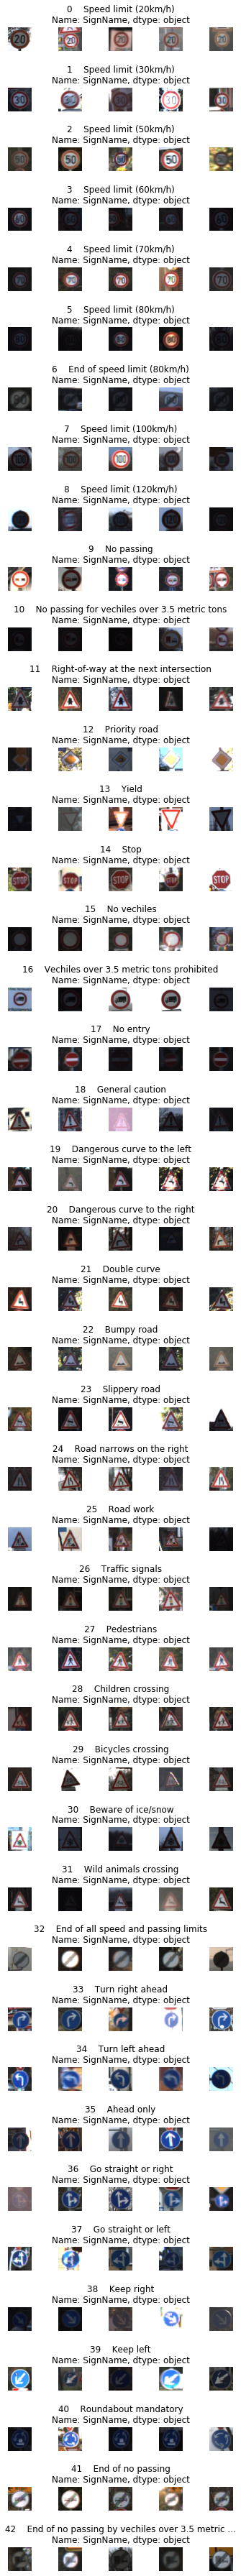

In [0]:
n_cols= 5
n_classes= 43

fig,axes = plt.subplots(nrows=n_classes,ncols=n_cols,figsize=(5,50))
fig.tight_layout()

for i in range(n_cols):
    for j in range(n_classes):
        
        selected_images= x_train[y_train==j]
        image = selected_images[random.randint(0,(len(selected_images)-1)),:,:,:]
        axes[j][i].imshow(image)
        axes[j][i].axis('off')

        if i==2:
          axes[j][i].set_title(str(data.SignName[data.ClassId==j]))
            

In [0]:
import cv2

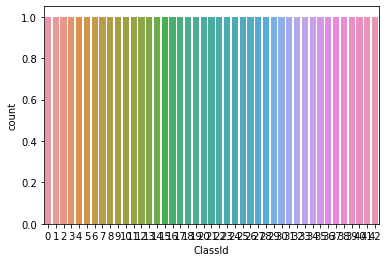

In [0]:
sns.countplot(data.ClassId)
plt.show()

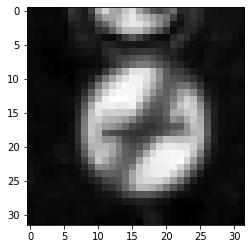

In [0]:
def grayscale(image):
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  return gray

plt.imshow(grayscale(x_train[0]),cmap='gray')
plt.show()

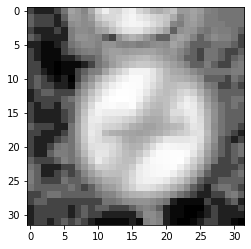

In [0]:
def equalize(image):
  image = cv2.equalizeHist(image)
  return image

img= grayscale(x_train[0])
img= equalize(img)
plt.imshow(img,cmap='gray')
plt.show()

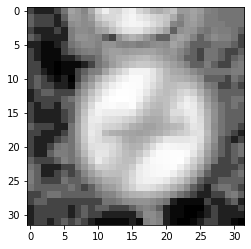

In [0]:
def preprocess(image):
  image = equalize(grayscale(image))
  image= image/255
  return image

plt.imshow(preprocess(x_train[0]),cmap='gray')
plt.show()

In [0]:
x_train = np.array(list(map(preprocess,x_train)))
x_test = np.array(list(map(preprocess,x_test)))
x_valid = np.array(list(map(preprocess,x_valid)))


In [0]:
from keras.utils.np_utils import to_categorical

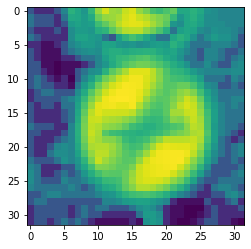

In [0]:
plt.imshow(x_train[0])
plt.show()

In [0]:
x_train = x_train.reshape(x_train.shape[0],32,32,1)
x_test = x_test.reshape(x_test.shape[0],32,32,1)
x_valid = x_valid.reshape(x_valid.shape[0],32,32,1)

y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_valid = to_categorical(y_valid,43)


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen= ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.1,rotation_range=10,shear_range=0.1)

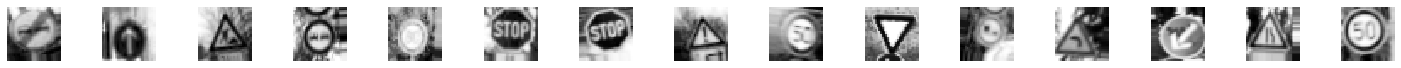

In [0]:
#calling the datagenerator to augment in real time

batches= datagen.flow(x_train,y_train,batch_size=20)

x_batch,y_batch = next(batches)

fig,axes = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axes[i].imshow(x_batch[i].reshape(32,32),cmap='gray')
  axes[i].axis('off')



In [0]:
from keras.models import Sequential
from keras.layers import Dense,Flatten ,Dropout
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.optimizers import Adam

In [0]:
def lenet_model():
  model= Sequential()
  model.add(Conv2D(60,kernel_size=(5,5),input_shape=(32,32,1),activation='relu'))
    
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
 

  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Conv2D(30,(3,3),activation='relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(Dropout(0.25)) #commented out after fit generator
  model.add(Flatten())
    
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes,activation='softmax'))
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy']) 
  return model

model= lenet_model()
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)              

In [0]:
h= model.fit_generator(datagen.flow(x_train,y_train,batch_size=50),steps_per_epoch=2000,epochs=10,verbose=1,validation_data=(x_valid,y_valid),shuffle=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





2000/2000 [==============================] - 65s 33ms/step - loss: 0.9016 - acc: 0.7351 - val_loss: 0.1059 - val_acc: 0.9707
Epoch 2/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.1962 - acc: 0.9386 - val_loss: 0.0969 - val_acc: 0.9785
Epoch 3/10
2000/2000 [==============================] - 50s 25ms/step - loss: 0.1282 - acc: 0.9602 - val_loss: 0.0929 - val_acc: 0.9776
Epoch 4/10
2000/2000 [==============================] - 50s 25ms/step - loss: 0.0980 - acc: 0.9693 - val_loss: 0.1200 - val_acc: 0.9780
Epoch 5/10
2000/2000 [==============================] - 50s 25ms/step - loss: 0.0832 - acc: 0.9745 - val_loss: 0.0652 - val_acc: 0.9823
Epoch 6/10
2000/2000 [==============================] - 50s 25ms/step - loss: 0.0714 - acc: 0.9775 - val_loss: 0.0785 - val_acc: 0.9830
Epoch 7/10
2000/2000 [==============================] - 50s 25ms/step - loss: 0.06

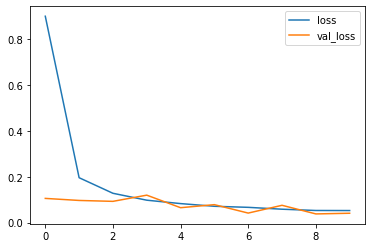

In [0]:
plt.plot(h.history['loss'],label='loss')
plt.plot(h.history['val_loss'],label='val_loss')  #if val_loss is greater than loss,then underfit
plt.legend()                                      #if val_loss if less than loss, then overfit  
plt.show()  

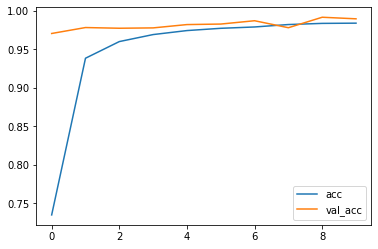

In [0]:
plt.plot(h.history['acc'],label='acc')
plt.plot(h.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

In [0]:
model.save('traffic_model.h5')
from google.colab import files
files.download('traffic_model.h5')
